# Libraries

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Data Preparation

### Functions

In [34]:
def prepare_data(csv_file, countries_to_keep, value_name):
    # Read csv
    csv_file = pd.read_csv(csv_file)
    
    # Filter countries
    csv_file = csv_file[csv_file['Country Code'].isin(countries_to_keep)]
    csv_file = csv_file.drop(columns=['Country Name'])

    # Transpose so years are a column
    csv_file_plot = csv_file.set_index('Country Code').transpose().reset_index()
    csv_file_plot = csv_file_plot.rename(columns={'index': 'Year'})

    # Convert Year to integer
    csv_file_plot['Year'] = csv_file_plot['Year'].astype(int)
    
    # Melt the DataFrame to long format for Seaborn
    csv_file_melted = csv_file_plot.melt(id_vars='Year', var_name='Country', value_name=value_name)

    return csv_file_melted


# Function to clean country names
def clean_country(name):
    # Remove everything in parentheses and brackets
    name = re.sub(r"\(.*?\)", "", name)  # remove (GBR)
    name = re.sub(r"\[.*?\]", "", name)  # remove [a]
    return name.strip()  # remove leading/trailing whitespace

### Reading and cleaning

In [35]:
gdp = pd.read_csv('datasets/GDP_data.csv')
medal_data = pd.read_csv('datasets/medal_data.csv')
population = pd.read_csv('datasets/population.csv')
olympics = pd.read_csv('datasets/olympics_dataset.csv')
noc_regions = pd.read_csv('datasets/noc_regions.csv')
host_city = pd.read_csv('datasets/host_cities.csv')
print(host_city)

                      City         Country  NOC  Summer Winter  Year  \
0                   Athens          Greece  GRE       I    NaN  1896   
1                    Paris          France  FRA      II    NaN  1900   
2                St. Louis   United States  USA     III    NaN  1904   
3                   London  United Kingdom  GBR      IV    NaN  1908   
4                Stockholm          Sweden  SWE       V    NaN  1912   
5                  Antwerp         Belgium  BEL     VII    NaN  1920   
6                 Chamonix          France  FRA     NaN      I  1924   
7                    Paris          France  FRA    VIII    NaN  1924   
8               St. Moritz     Switzerland  SUI     NaN     II  1928   
9                Amsterdam     Netherlands  NED      IX    NaN  1928   
10             Lake Placid   United States  USA     NaN    III  1932   
11             Los Angeles   United States  USA       X    NaN  1932   
12  Garmisch-Partenkirchen    Nazi Germany  GER     NaN     IV  

In [36]:
# Apply to NOC or Team column
medal_data['NOC'] = medal_data['NOC'].apply(clean_country)
print(medal_data)

      Year Rank            NOC  Gold  Silver  Bronze  Total
0     2024    1  United States    40      44      42    126
1     2024    2          China    40      27      24     91
2     2024    3          Japan    20      12      13     45
3     2024    4      Australia    18      19      16     53
4     2024    5         France    16      26      22     64
...    ...  ...            ...   ...     ...     ...    ...
1431  1896    7        Austria     2       1       2      5
1432  1896    8      Australia     2       0       0      2
1433  1896    9        Denmark     1       2       3      6
1434  1896   10    Switzerland     1       2       0      3
1435  1896   11     Mixed team     1       0       1      2

[1436 rows x 7 columns]


In [37]:
# Country names standardization
reverse_mapping = {
    "Czechia": "Czech Republic",
    "Iran, Islamic Rep.": "Iran",
    "Cabo Verde": "Cape Verde",
    "North Macedonia": "Macedonia",
    "Korea, Dem. People's Rep.": "North Korea",
    "Slovak Republic": "Slovakia",
    "Venezuela, RB": "Venezuela",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Virgin Islands (U.S.)": "Virgin Islands",
    "Viet Nam": "Vietnam",
    "St. Lucia": "Saint Lucia",
    "Syrian Arab Republic": "Syria",
    "Turkiye": "Turkey",
    "Puerto Rico (US)": "Puerto Rico",
    "Egypt, Arab Rep.": "Egypt",
    "Cote d'Ivoire": "Ivory Coast",
    "Korea, Rep.": "South Korea",
    "Bahamas, The": "Bahamas",
    "Hong Kong SAR, China": "Hong Kong",
    "Russian Federation": "Russia",
    "Yemen, Rep.": "Yemen"
}

gdp['Country_Standard'] = gdp['Country Name'].replace(reverse_mapping)
population['Country_Standard'] = population['Country Name'].replace(reverse_mapping)

# Data Analysis

## Top 10 gold medals

In [38]:
# Group by country (NOC) and sum medals
country_total = (
    medal_data.groupby('NOC')[['Gold', 'Silver', 'Bronze', 'Total']]
    .sum()
    .sort_values(by='Gold', ascending=False)
    .reset_index()
)

# Display top 10
print(country_total.head(10))

              NOC  Gold  Silver  Bronze  Total
0   United States  1107     879     782   2768
1    Soviet Union   395     319     296   1010
2  United Kingdom   305     342     344    991
3           China   303     226     198    727
4          France   245     281     304    830
5           Italy   233     206     230    669
6         Germany   221     225     259    705
7           Japan   189     162     193    544
8         Hungary   187     162     183    532
9       Australia   180     192     226    598


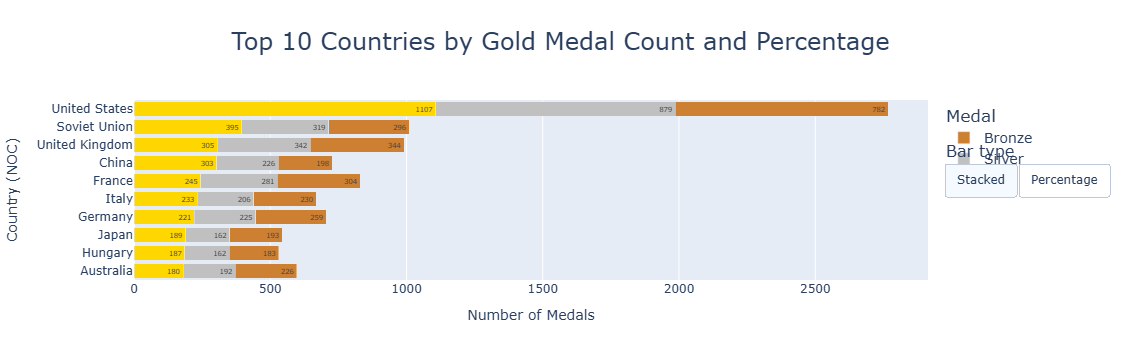

In [39]:
# Top 10 countries by gold
top10 = country_total.sort_values(by='Gold', ascending=False).head(10)
# Reverse order for horizontal bar chart so US (highest) is on top
top10 = top10.iloc[::-1]
medals = ['Gold', 'Silver', 'Bronze']
colors = ['#FFD700', '#C0C0C0', '#CD7F32']

# Top 10 by gold medal count
top10_gold = country_total.sort_values('Gold', ascending=False).head(10)
top10_gold = top10_gold.iloc[::-1]

# Top 10 by gold medal percentage
top10_gold['Gold_pct'] = top10_gold['Gold'] / top10_gold['Total']
top10_pct = top10_gold.sort_values('Gold_pct', ascending=False)
top10_pct = top10_pct.iloc[::-1]

# Precompute percentages for percentage mode
percent_text = {}
for medal in medals:
    percent_text[medal] = [f"{v/sum(top10[medals].iloc[i]):.1%}" 
                            for i,v in enumerate(top10[medal])]
fig = go.Figure()

# Add traces
for medal in medals:
    customdata = list(zip(top10[medal], top10['Total']))
    fig.add_trace(go.Bar(
        y=top10['NOC'],
        x=top10[medal],
        name=medal,
        orientation='h',
        marker_color=colors[medals.index(medal)],
        text=top10[medal],  # initial labels = counts
        textposition='inside',
        customdata=customdata,
        hovertemplate="%{y}<br>" + medal + ": %{customdata[0]}<br>Total Medals: %{customdata[1]}<extra></extra>"
    ))

# Buttons for absolute vs percentage
fig.update_layout(
    # Title formatting
    title="Top 10 Countries by Gold Medal Count and Percentage",
    title_font=dict(size=24),
    title_x=0.5,
    # Legend formatting
    legend_title_text="Medal",
    legend=dict(font=dict(size=14)),
    # Axis and chart formatting
    barmode='stack',
    xaxis_title="Number of Medals",
    yaxis_title="Country (NOC)",
    # Buttons setup
    updatemenus=[dict(
        type="buttons",
        direction="right",
        x=1.02,          # move to the far right of the plotting area
        y=0.65,           # align with the top (title)
        xanchor='left',  # anchor the left side of the buttons at x
        yanchor='top',   # anchor the top of buttons at y
        showactive=True,
        buttons=[
            dict(
                label="Stacked",
                method="update",
                args=[
                    {
                        "y": [top10_gold['NOC']] * 3,
                        "x": [top10_gold[m] for m in medals],
                        "text": [top10_gold[m] for m in medals],
                    },
                    {
                        "barmode": "stack",
                        "barnorm": "",
                        "xaxis": {"title": "Number of Medals"}
                    }
                ],
            ),
            dict(
                label="Percentage",
                method="update",
                args=[
                    {
                        "y": [top10_pct['NOC']] * 3,
                        "x": [top10_pct[m] for m in medals],
                        "text": [percent_text[m] for m in medals],
                    },
                    {
                        "barmode": "stack",
                        "barnorm": "percent",
                        "xaxis": {"title": "Share of Medals"}
                    }
                ],
            )
        ],
    )],
)

# Menu for buttons
fig.add_annotation(
    x=1.02,            # align with the buttons' x
    y=0.65,            # slightly above the buttons
    xref="paper",
    yref="paper",
    text="Bar type",
    showarrow=False,
    font=dict(size=16),
    xanchor="left",
    yanchor="bottom"
)

# Save as html and show
fig.write_html("plots/Plot_top10_medals_stacked_bar_new.html", include_plotlyjs='cdn', full_html=True)
fig.show()

## Factor 1 - GDP

### 1.1 - Standardize country names across medal and GDP data

In [40]:
# Unique country names in each dataset
medal_countries = set(medal_data['NOC'].unique())
gdp_countries = set(gdp['Country Name'].unique())

# Countries present in both datasets
matches = medal_countries & gdp_countries

# Countries in medal_data but not in GDP
medal_only = medal_countries - gdp_countries

# Countries in GDP but not in medal_data
gdp_only = gdp_countries - medal_countries

print("Matches:", sorted(matches))
print()
print("Medal data only:", sorted(medal_only))
print()
print("GDP data only:", sorted(gdp_only))

Matches: ['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Bermuda', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Haiti', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Latvia', 'Lebanon', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Namibia', 'Netherlands', 'New Zealand', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland'

### 1.2 - Prepare GDP column to use latest GDP available

In [41]:
gdp_years = [str(y) for y in range(1960, 2025)]  # all year columns as strings

# Function to get latest available GDP for each row
def latest_gdp(row):
    # iterate from latest year to earliest
    for year in reversed(gdp_years):
        if pd.notna(row[year]):
            return row[year]
    return np.nan  # if all are NaN

# Apply row-wise
gdp['GDP_latest'] = gdp.apply(latest_gdp, axis=1)

### 1.3 - Merging with total medals + clean data

In [42]:
# Merge GDP with medal totals into new df
merged_df = pd.merge(
    gdp[['Country_Standard','GDP_latest']],
    country_total[['NOC','Gold','Total']],
    left_on='Country_Standard',
    right_on='NOC',
    how='left'
)

# Fill 0 medals for countries without medals
merged_df['Total'] = merged_df['Total'].fillna(0)
merged_df['Gold'] = merged_df['Gold'].fillna(0)

# Keep only countries with medals and GDP data available
plot_df = merged_df[(merged_df['Total'] > 0) & (merged_df['GDP_latest'].notna())]

### 1.4 - Merging with population

In [43]:
# Merge population with medal count
merged_pop = pd.merge(
    population,
    country_total[['NOC','Gold', 'Total']],
    left_on='Country_Standard',
    right_on='NOC',
    how='left'
)

# Merge GDP with Population
merged_gdp_population = pd.merge(
    plot_df[['Country_Standard','GDP_latest', 'Gold', 'Total', 'NOC']],
    merged_pop[['Country_Standard', '2024']],
    on='Country_Standard',
    how='left'
)
merged_gdp_population.rename(columns={'2024': 'Population'}, inplace=True)

### 1.5 - Highlight top 5 countries

In [44]:
# Find top 5 countries by total gold medals
top5_gdp_gold = merged_gdp_population.sort_values('Gold', ascending=False).head(5)
# Mark top 5 countries
merged_gdp_population['Gold Medal Count'] = 'Other'
top5_gdp_gold['Gold Medal Count'] = 'Top 5 Gold Medals'
# Combine with top 5 countries by gold medals
plot_df_combined = pd.concat([merged_gdp_population, top5_gdp_gold], ignore_index=True)

# Scale population for bubble sizes
plot_df_combined['Population (millions)'] = (plot_df_combined['Population'])/1e6  # square root scaling
min_size, max_size = 50, 2000  # min and max bubble size

# Top 5 + Others, excluding Cuba
main_df = plot_df_combined[plot_df_combined['Country_Standard'] != 'Cuba']

### 1.6 - Plotting

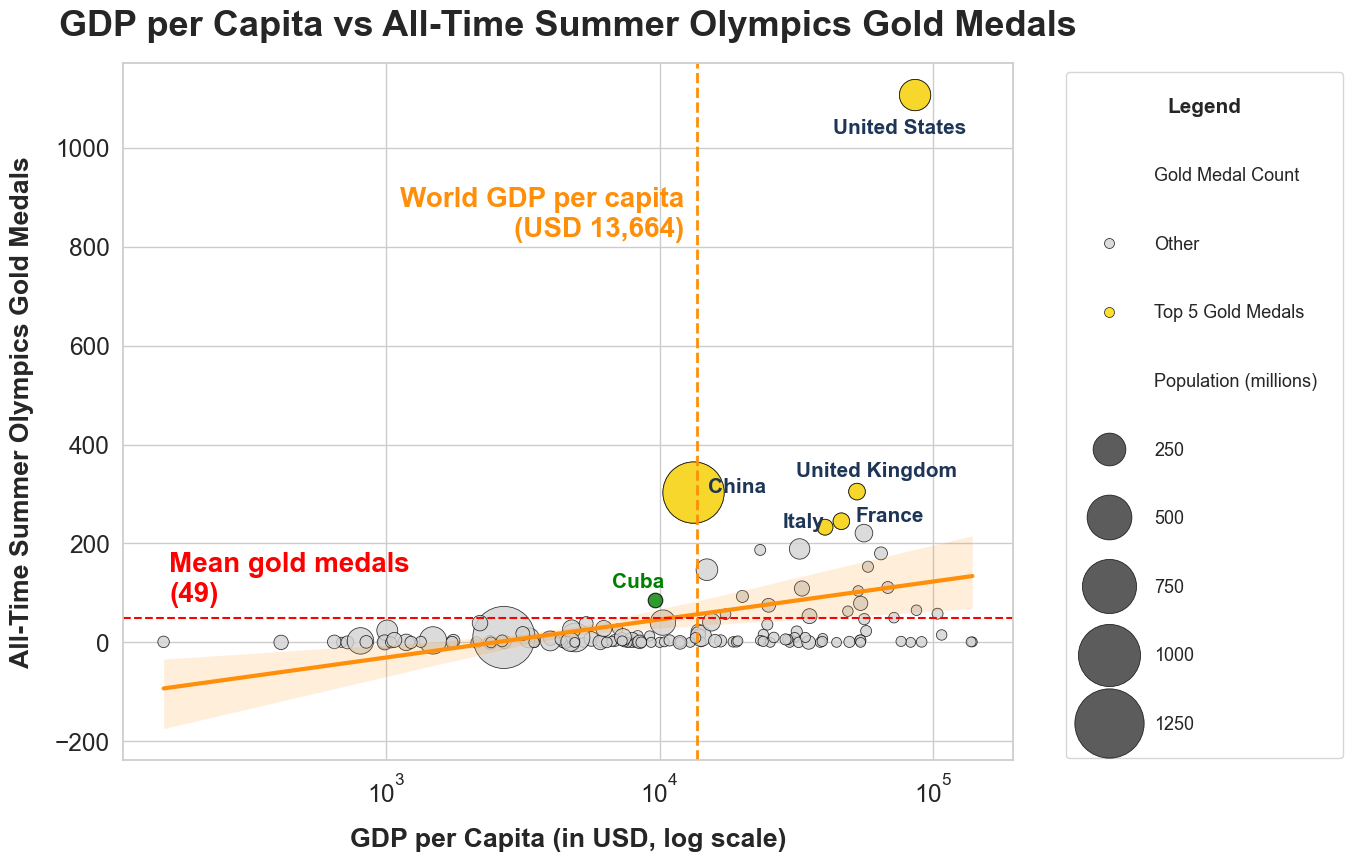

In [45]:
# Plot
sns.set(style="whitegrid", font_scale=1.6)
plt.figure(figsize=(14,9))

scatter = sns.scatterplot(
    data=main_df,
    x='GDP_latest',
    y='Gold',
    hue='Gold Medal Count',          # top 5 vs others
    size='Population (millions)',    # bubble size
    sizes=(min_size, max_size),
    palette={'Other':'lightgray', 'Top 5 Gold Medals':'#ffd700'},
    edgecolor='black',
    alpha=0.8
)

# Cuba bubble
cuba_df = plot_df_combined[plot_df_combined['Country_Standard'] == 'Cuba']
sns.scatterplot(
    data=cuba_df,
    x='GDP_latest',
    y='Gold',
    s=cuba_df['Population (millions)']*10,  # scale bubble like others
    color='green',
    edgecolor='black',
    alpha=0.8,
    legend=False  # do not include Cuba in legend
)
# Annotate Cuba 
cuba_row = cuba_df.iloc[0]
ax = plt.gca()
ax.text(
    cuba_row['GDP_latest']*0.7,  # slightly left
    cuba_row['Gold']*1.3,        # slightly above
    'Cuba',
    fontsize=15,
    fontweight='bold',
    color='green'
)

# [Step : Add regression and quadrant lines + annotations]
# Regression line
sns.regplot(
    data=plot_df_combined,
    x='GDP_latest',
    y='Gold',
    scatter=False,
    logx=True,
    line_kws={'color':'#ff8e09', 'linestyle':'-', 'linewidth':3},
)
# Get current Axes
ax = plt.gca()

# ean gold medals line
mean_gold = 49
ax.axhline(y=mean_gold, color='red', linestyle='--', linewidth=1.5)
# World gdp per capita line
world_gdp = 13663.9924550685
plt.axvline(x=world_gdp, color='#ff8e09', linestyle='--', linewidth=2, label='_nolegend_')
plt.text(
    world_gdp * 0.9,
    plt.ylim()[1] * 0.7,
    f'World GDP per capita\n(USD {world_gdp:,.0f})',
    color='#ff8e09',
    fontsize=20,
    fontweight='bold',
    ha='right'
)
# Add annotation slightly above the line, slightly right of y-axis
ax.text(
    x = plot_df_combined['GDP_latest'].min() * 1.05,  # slightly right of left edge
    y = mean_gold * 1.7,                             # slightly above the line
    s = f'Mean gold medals\n({mean_gold})',
    color='red',
    fontsize=20,
    fontweight='bold'
)


# Annotations for top 5 countries
offsets = {
    'United States': (0.5, 0.93),
    'Italy': (0.7, 1.0),
    'United Kingdom': (0.6, 1.1),
    'China': (1.13, 1.0),
    'France': (1.13, 1.0)
}
for idx, row in top5_gdp_gold.iterrows():
    x_off, y_off = offsets.get(row['NOC'], (1.05, 1.05))
    plt.text(
        row['GDP_latest'] * x_off,
        row['Gold'] * y_off,
        row['NOC'],
        fontsize=15,
        fontweight='bold',
        color='#1D3557'
    )
    
# Axis settings
plt.xscale('log')
plt.xlabel('GDP per Capita (in USD, log scale)', fontweight='bold', labelpad=15)
plt.ylabel('All-Time Summer Olympics Gold Medals', fontweight='bold', labelpad=15)
plt.title('GDP per Capita vs All-Time Summer Olympics Gold Medals', fontsize=26, fontweight='bold', pad=20)

# Customize legend
plt.legend(
    title='Legend',
    fontsize=13,           # text size
    title_fontsize=15,     # title size
    markerscale=1.2,       # scale bubbles in legend
    labelspacing=2.8,      # vertical spacing between entries
    borderpad=1.385,         # padding inside legend box
    handletextpad=1.5,     # space between bubble and text
    bbox_to_anchor=(1.05, 1.0),  # move legend outside plot
    loc='upper left'
)
plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')
plt.tight_layout()

# Save & show
plt.savefig('Plot_goldmedals_vs_gdp_combinedLegend.png', dpi=300)
plt.show()

## Factor 2 - Number of athletes

### 2.1 - Count number of unique athletes per country

In [46]:
# Filter Summer Olympics only
filter_df = olympics.loc[olympics['Season'] == 'Summer', ['Year', 'NOC', 'Name', 'Sex', 'Team']]

# Create a synthetic unique key per athlete
filter_df['UniqueAthlete'] = (
    filter_df['Name'].astype(str) + '_' +
    filter_df['Sex'].astype(str) + '_' +
    filter_df['Team'].astype(str)
)

# Count unique athletes per year and country
unique_athletes_by_year_country = (
    filter_df.groupby(['Year', 'NOC'])['UniqueAthlete']
    .nunique()
    .reset_index()
)

# Rename columns
unique_athletes_by_year_country.columns = ['Year', 'NOC', 'Unique_Athletes']

# Sum unique athletes across all years per country
all_time_participants = (
    unique_athletes_by_year_country
    .groupby('NOC')['Unique_Athletes']
    .sum()
    .reset_index()
)

### 2.2 - Map teams into their respective NOCs

In [47]:
team_noc_map = (
    olympics[['Team', 'NOC']]
    .drop_duplicates()
    .sort_values(['Team', 'NOC'])
)

# Group all NOCs belonging to the same Team into one row
team_to_nocs = (
    team_noc_map.groupby('Team')['NOC']
    .unique()
    .reset_index()
    .sort_values('Team')
)

### 2.3 - Map NOCs to countries

In [48]:
# Fix known unmapped or special NOCs
noc_fix = {
    'AIN': 'Individual Neutral Athletes',  # Neutral athletes (e.g. 2024)
    'EOR': 'Refugee Olympic Team',         # IOC Refugee Team
    'IVB': 'British Virgin Islands',       # Caribbean
    'LIB': 'Lebanon',                      # Lebanon
    'ROC': 'Russia'                        # Russian Olympic Committee
}

# Merge with participants data
merged_participants = pd.merge(
    all_time_participants,
    noc_regions[['NOC', 'region']],   # only keep needed columns
    on='NOC',
    how='left'
)

# Apply fixes and create final Country column
merged_participants['Country'] = merged_participants['region']  # start with CSV mapping
merged_participants.loc[merged_participants['Country'].isna(), 'Country'] = merged_participants['NOC'].map(noc_fix)

# Drop the old region column
merged_participants = merged_participants.drop(columns=['region'])

# Aggregate to modern country
noc_to_modern_country = {
    # Germany
    'FRG': 'Germany',
    'GDR': 'Germany',
    'EUA': 'Germany',
    'GER': 'Germany',

    # Russia / Soviet Union
    'URS': 'Russia',
    'RUS': 'Russia',
    'ROC': 'Russia',
    'EUN': 'Russia',

    # Lebanon
    'LIB': 'Lebanon',
    'LBN': 'Lebanon',

    # Zimbabwe
    'RHO': 'Zimbabwe',
    'ZIM': 'Zimbabwe',

    # Special / neutral
    'AIN': 'Individual Neutral Athletes',
    'EOR': 'Refugee Olympic Team',
    'ROT': 'Refugee Olympic Team',
    'IVB': 'British Virgin Islands'
}

### 2.4 - Calculations (gold medal sum and gold medal/participant)

In [49]:
# Step 1: Sum duplicates and merge with medals
participants_sum = merged_participants.groupby('Country', as_index=False)['Unique_Athletes'].sum()
medals_sum = country_total.groupby('NOC', as_index=False)['Gold'].sum()

merged_participant_medal = pd.merge(
    participants_sum,
    medals_sum,
    left_on='Country',
    right_on='NOC',
    how='inner'
).drop(columns=['NOC'])

# Add gold medals per participant column
merged_participant_medal['Medals_per_Participant'] = (
    merged_participant_medal['Gold'] / merged_participant_medal['Unique_Athletes']
)

### 2.5 - Highlight and mark countries

In [50]:
# Mark historical countries
historical_countries = [
    'Soviet Union', 'Yugoslavia', 'East Germany', 'West Germany',
    'United Arab Republic', 'Timor-Leste', 'South Yemen', 'North Yemen', 'West Indies Federation'
]
merged_participant_medal['Historical'] = merged_participant_medal['Country'].isin(historical_countries)

# Keep only countries with medals
merged_participant_medal = merged_participant_medal[merged_participant_medal['Gold'] > 0]

# Sort by number participants to get top 5
top5_participants = merged_participant_medal.sort_values('Unique_Athletes', ascending=False).head(5)
top5_medals_per_participant = merged_participant_medal.sort_values('Medals_per_Participant', ascending=False).head(5)

# Split historical vs modern countries
modern = merged_participant_medal[~merged_participant_medal['Historical']]
historical = merged_participant_medal[merged_participant_medal['Historical']]

### 2.6 - Plotting

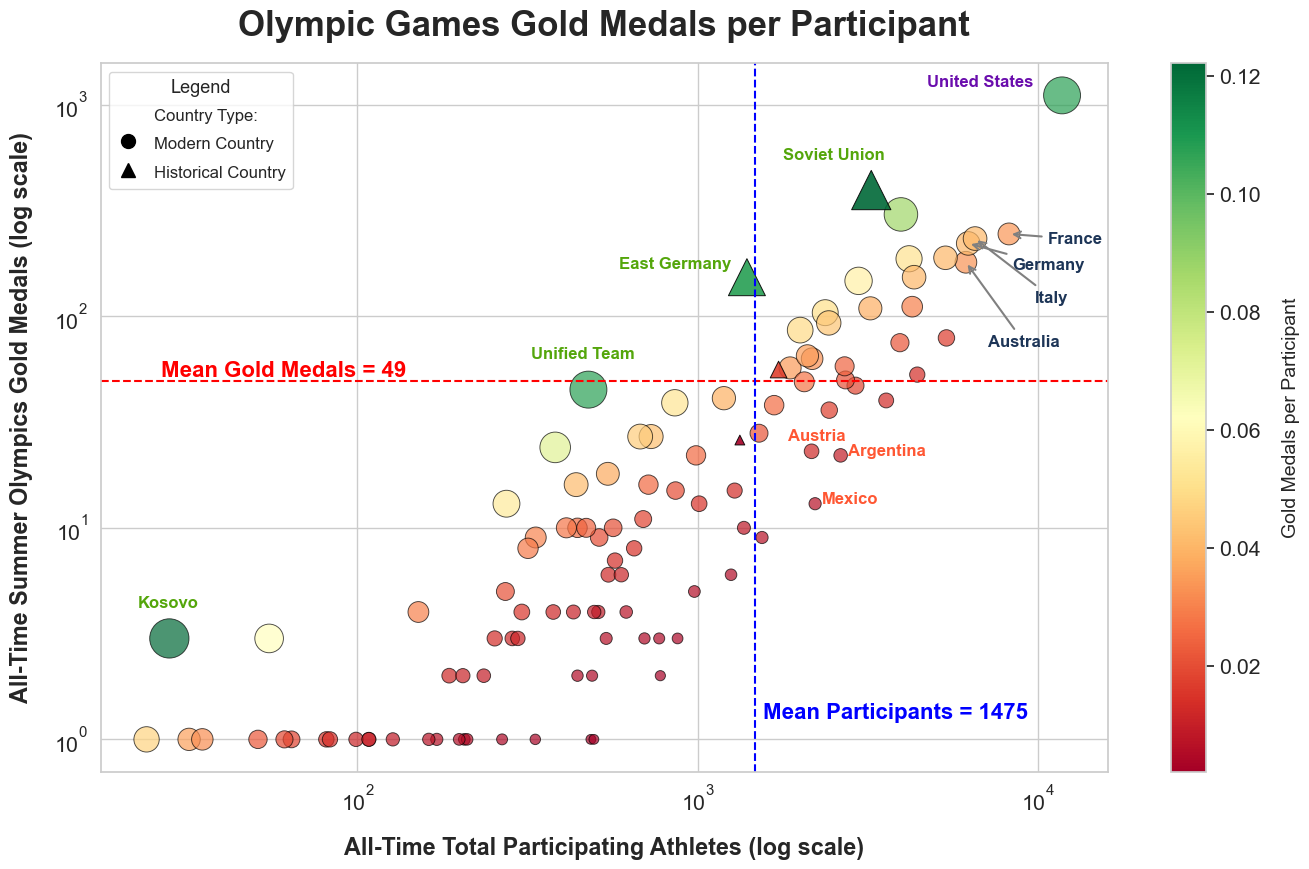

In [51]:
sns.set(style="whitegrid", font_scale=1.4)
fig, ax = plt.subplots(figsize=(14,9))

# Red-to-green colormap for Medals_per_Participant
cmap = mpl.colormaps.get_cmap("RdYlGn")  # ✅ no warning

# Plot modern countries
sns.scatterplot(
    data=modern,
    x='Unique_Athletes',
    y='Gold',
    size='Medals_per_Participant',
    hue='Medals_per_Participant',
    sizes=(50, 800),
    palette=cmap,
    alpha=0.7,
    edgecolor='black',
    marker='o',
    ax=ax,
    legend=False
)

# Plot historical countries
sns.scatterplot(
    data=historical,
    x='Unique_Athletes',
    y='Gold',
    size='Medals_per_Participant',
    hue='Medals_per_Participant',
    sizes=(50, 800),
    palette=cmap,
    alpha=0.9,
    edgecolor='black',
    marker='^',
    ax=ax,
    legend=False
)

# Annotate top 5
top5_participants_sorted = top5_participants.sort_values('Unique_Athletes', ascending=False).reset_index()
top5_medals_per_participant_sorted = top5_medals_per_participant.sort_values('Medals_per_Participant', ascending=False).reset_index()

# Track countries already annotated (for US or overlapping)
annotated_countries = set()

# Top 5 participants (with leader lines downward-right)
top5_offsets = {
    'France': (0.30, -0.10),
    'Germany': (0.35, -0.25),
    'Italy': (0.5, -0.5),
    'Australia': (0.16, -0.6)
}
# Annotate top 5 participants
for idx, row in top5_participants_sorted.iterrows():
    country = row['Country']
    if country in top5_offsets and country != "United States":
        x_offset, y_offset = top5_offsets[country]
        ax.annotate(
            country,
            xy=(row['Unique_Athletes'], row['Gold']),
            xytext=(row['Unique_Athletes']*(1 + x_offset), row['Gold']*(1 + y_offset)),
            fontsize=12,
            fontweight='bold',
            color='#1D3557',
            arrowprops=dict(arrowstyle="->", color='gray', lw=1.5)
        )

# Top 5 gold medals per participant (above-left, no arrow)
for i, row in top5_medals_per_participant_sorted.iterrows():
    country = row['Country']
    if country in annotated_countries or country == "United States":
        # US or overlapping top5: annotate once with distinct color
        ax.text(
            row['Unique_Athletes']*0.4,
            row['Gold']*1.1,
            country,
            fontsize=12,
            fontweight='bold',
            color='#6A0DAD'  # purple for both top5
        )
        annotated_countries.add(country)  # add US so it won't appear again
    elif country == "Kosovo":
        # Kosovo: manual offset
        ax.text(
            row['Unique_Athletes']*0.81,  # adjust X offset as needed
            row['Gold']*1.4,             # adjust Y offset as needed
            country,
            fontsize=12,
            fontweight='bold',
            color='#54a60b'  # same green as normal
        )
        annotated_countries.add(country)
    elif country == "Soviet Union":
        ax.text(
            row['Unique_Athletes']*0.55,  # adjust X offset as needed
            row['Gold']*1.4,             # adjust Y offset as needed
            country,
            fontsize=12,
            fontweight='bold',
            color='#54a60b'  # same green as normal
        )
        annotated_countries.add(country)
    elif country == "Unified Team":
        ax.text(
            row['Unique_Athletes']*0.68,  # adjust X offset as needed
            row['Gold']*1.4,             # adjust Y offset as needed
            country,
            fontsize=12,
            fontweight='bold',
            color='#54a60b'  # same green as normal
        )
        annotated_countries.add(country)
    else:
        ax.text(
            row['Unique_Athletes']*0.42,
            row['Gold']*1.1,
            country,
            fontsize=12,
            fontweight='bold',
            color='#54a60b'  # green for medals per participant
        )
        annotated_countries.add(country)

# Additional countries to annotate manually with custom offsets
highlight_countries_offsets = {
    'Argentina': (1.05, 1),  # x_multiplier, y_multiplier
    'Mexico': (1.05, 1),
    'Austria':(0.85, 1.125)
}

for country, (x_mult, y_mult) in highlight_countries_offsets.items():
    row = merged_participant_medal[merged_participant_medal['Country'] == country].iloc[0]
    ax.text(
        row['Unique_Athletes'] * x_mult,
        row['Gold'] * y_mult,
        country,
        fontsize=12,
        fontweight='bold',
        color='#FF5733'  # distinct color for highlighted countries
    )

# Log scale axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('All-Time Total Participating Athletes (log scale)', fontweight='bold', labelpad=15)
ax.set_ylabel('All-Time Summer Olympics Gold Medals (log scale)', fontweight='bold', labelpad=15)
ax.set_title('Olympic Games Gold Medals per Participant', fontsize=25, fontweight='bold', pad=20)

# Colorbar
norm = mpl.colors.Normalize(
    vmin=merged_participant_medal['Medals_per_Participant'].min(),
    vmax=merged_participant_medal['Medals_per_Participant'].max()
)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Gold Medals per Participant', fontsize=14, labelpad=15)

# Custom combined legend

# Create handles for modern & historical symbols
# Marker legends (country types)
modern_patch = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                             markersize=10, label='Modern Country')
historical_patch = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                 markersize=10, label='Historical Country')

# Build legend entries
legend_elements = [
    # Subsection title for country types
    mlines.Line2D([], [], color='none', label='Country Type:', linewidth=0),
    modern_patch,
    historical_patch,
]

legend = ax.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=12,
    frameon=True,
    title='Legend',
    title_fontsize=13,
    handlelength=1.5,
    handleheight=1.5
)

# Compute means
mean_participants = merged_participant_medal['Unique_Athletes'].mean()
mean_gold = merged_participant_medal['Gold'].mean()

# LINES
# Mean gold
ax.axhline(y=mean_gold, color='red', linestyle='--', linewidth=1.5)
ax.text(
    x=merged_participant_medal['Unique_Athletes'].min()*1.1,  # slightly right of y-axis
    y=mean_gold*1.05,
    s=f'Mean Gold Medals = {int(mean_gold)}',
    color='red',
    fontsize=16,
    fontweight='bold'
)

# Mean participants
ax.axvline(x=mean_participants, color='blue', linestyle='--', linewidth=1.5)
ax.text(
    x=mean_participants*1.05,
    y=merged_participant_medal['Gold'].min()*1.2,  # slightly above x-axis
    s=f'Mean Participants = {int(mean_participants)}',
    color='blue',
    fontsize=16,
    fontweight='bold',
    va='bottom'
)

plt.tight_layout()
plt.savefig('Plot_medals_vs_participants_withAnnotation.png', dpi=300)
plt.show()


## Factor 3 - Host country effect

### 3.1 - Filter and update host countries data

In [52]:
# Filtered Summer Olympics DataFrame
summer_host_cities = host_city[host_city['Summer'].notna()].sort_values('Year').reset_index(drop=True)

# Manually create new rows for 2020 and 2024
new_hosts = pd.DataFrame([
    {
        'City': 'Tokyo',
        'Country': 'Japan',
        'NOC': 'JPN',
        'Summer': 'XXXII',  # 32nd Olympiad
        'Winter': pd.NA,
        'Year': 2020,
        'Latitude': 35.6762,
        'Longitude': 139.6503
    },
    {
        'City': 'Paris',
        'Country': 'France',
        'NOC': 'FRA',
        'Summer': 'XXXIII',  # 33rd Olympiad
        'Winter': pd.NA,
        'Year': 2024,
        'Latitude': 48.8566,
        'Longitude': 2.3522
    }
])

# Append the new rows
summer_host_cities = pd.concat([summer_host_cities, new_hosts], ignore_index=True)

# Sort by year again
summer_host_cities = summer_host_cities.sort_values('Year').reset_index(drop=True)

# Select only the desired columns
summer_host_cities_simple = summer_host_cities[['City', 'Country', 'NOC', 'Year']].copy()

# Check
summer_host_cities_simple.head(35)

,City,Country,NOC,Year
0,Athens,Greece,GRE,1896
1,Paris,France,FRA,1900
2,St. Louis,United States,USA,1904
3,London,United Kingdom,GBR,1908
4,Stockholm,Sweden,SWE,1912
5,Antwerp,Belgium,BEL,1920
6,Paris,France,FRA,1924
7,Amsterdam,Netherlands,NED,1928
8,Los Angeles,United States,USA,1932
9,Berlin,Nazi Germany,GER,1936


### 3.2 - Clean data and add host ranking + medal count (total & gold)

In [53]:
# Step 1: Clean the medal_data country names if needed
# Remove annotations like "(GER)[a]" if they exist
medal_data['Country_Clean'] = medal_data['NOC'].str.replace(r'\s*\(.*?\)|\[.*?\]', '', regex=True).str.strip()

# Step 2: Map country names to the 3-letter code (NOC)
gdp = pd.read_csv('GDP_data.csv')
countries_df = gdp[['Country Name','Country Code']].copy()
country_to_noc = dict(zip(countries_df['Country Name'], countries_df['Country Code']))

medal_data['NOC_Code'] = medal_data['Country_Clean'].map(country_to_noc)

# For unmatched countries, keep original name
medal_data['NOC_Code'] = medal_data['NOC_Code'].fillna(medal_data['Country_Clean'])

# Step 3: Merge host cities with medal data
# Merge on Year and NOC
host_with_medals = pd.merge(
    summer_host_cities_simple,
    medal_data[['Year','NOC_Code','Rank','Total']],
    how='left',
    left_on=['Year','NOC'],
    right_on=['Year','NOC_Code']
)

# Rename columns
host_with_medals.rename(columns={'Rank':'Host_Rank','Total':'Host_Medals'}, inplace=True)

# Drop the extra NOC_Code column
host_with_medals.drop(columns=['NOC_Code'], inplace=True)

# Drop stockholm 1956
host_with_medals = host_with_medals[~((host_with_medals['Year'] == 1956) & (host_with_medals['City'] == 'Stockholm'))]

# Fill NaN values
manual_ranks = {1896: 2, 1928: 8 , 1936: 1, 1972: 4, 1980: 1, 1988: 4, 2004: 15}
manual_medals = {1896: 47, 1928: 19, 1936: 101, 1972: 40, 1980: 195, 1988: 33, 2004: 16}

host_with_medals['Host_Rank'] = host_with_medals['Year'].map(manual_ranks).combine_first(host_with_medals['Host_Rank'])
host_with_medals['Host_Medals'] = host_with_medals['Year'].map(manual_medals).combine_first(host_with_medals['Host_Medals'])

host_with_medals.head(40)

,City,Country,NOC,Year,Host_Rank,Host_Medals
0,Athens,Greece,GRE,1896,2.0,47.0
1,Paris,France,FRA,1900,1,112.0
2,St. Louis,United States,USA,1904,1,234.0
3,London,United Kingdom,GBR,1908,1,146.0
4,Stockholm,Sweden,SWE,1912,2,65.0
5,Antwerp,Belgium,BEL,1920,5,36.0
6,Paris,France,FRA,1924,3,38.0
7,Amsterdam,Netherlands,NED,1928,8.0,19.0
8,Los Angeles,United States,USA,1932,1,110.0
9,Berlin,Nazi Germany,GER,1936,1.0,101.0


### 3.3 - Calculate metrics for other host countries during the years where they did not host 

In [54]:
# Ensure numeric columns
for col in ['Gold', 'Silver', 'Bronze', 'Total']:
    medal_data[col] = pd.to_numeric(medal_data[col], errors='coerce')

# Aggregate by Year + NOC
medal_data_agg = (
    medal_data
    .groupby(['Year', 'NOC', 'Country_Clean'], as_index=False)[['Gold', 'Silver', 'Bronze', 'Total']]
    .sum()
)

# Compute total gold medals for each Olympic year (all countries)
total_gold_all = (
    medal_data_agg
    .groupby('Year', as_index=False)['Gold']
    .sum()
    .rename(columns={'Gold': 'Total_Gold_All'})
)

# Prepare host-only subset
host_countries = host_with_medals['Country'].unique()
host_medals_df = medal_data_agg[medal_data_agg['Country_Clean'].isin(host_countries)].copy()

# Merge total golds into host_medals_df
host_medals_df = host_medals_df.merge(total_gold_all, on='Year', how='left')

# Compute gold medal share
host_medals_df['Gold_Percentage'] = (
    host_medals_df['Gold'] / host_medals_df['Total_Gold_All'] * 100
).round(2)

# Merge rank
if 'Rank' not in host_medals_df.columns and 'Rank' in medal_data.columns:
    host_medals_df = host_medals_df.merge(
        medal_data[['Year', 'Country_Clean', 'Rank']],
        on=['Year', 'Country_Clean'],
        how='left'
    )

# Convert ranks to numeric
host_medals_df['Rank'] = pd.to_numeric(host_medals_df['Rank'], errors='coerce')

print(host_medals_df.head(50))

    Year             NOC   Country_Clean  Gold  Silver  Bronze  Total  \
0   1896       Australia       Australia     2       0       0      2   
1   1896          France          France     5       4       2     11   
2   1896          Greece          Greece    10      18      19     47   
3   1896  United Kingdom  United Kingdom     2       3       2      7   
4   1896   United States   United States    11       7       2     20   
5   1900       Australia       Australia     0       0       3      3   
6   1900         Belgium         Belgium     6       6       6     18   
7   1900          France          France    31      41      40    112   
8   1900           Italy           Italy     3       2       0      5   
9   1900     Netherlands     Netherlands     1       2       3      6   
10  1900           Spain           Spain     1       0       0      1   
11  1900          Sweden          Sweden     0       0       1      1   
12  1900  United Kingdom  United Kingdom    20     

### 3.4 - Plotting

In [55]:
# Define metrics for visualization
metrics = ['Total', 'Gold_Percentage', 'Rank']
titles = ['Total Medals', 'Gold Medal Share (%)', 'Rank']
color_scales = ['Viridis', 'YlOrRd', 'Blues_r']  # reversed for rank

# Generate heatmaps
for metric, title, scale in zip(metrics, titles, color_scales):
    
    # Ensure metric column is numeric
    host_medals_df[metric] = pd.to_numeric(host_medals_df[metric], errors='coerce')

    # If country does not participate, rank will be set to NaN
    fill = 0 if metric != 'Rank' else np.nan
    
    # Pivot: rows=country, columns=year
    heatmap_df = host_medals_df.pivot_table(
        index='Country_Clean',
        columns='Year',
        values=metric,
        aggfunc='mean',
        fill_value=fill
    )
    
    # Create heatmap
    fig = px.imshow(
        heatmap_df,
        labels=dict(x="Olympic Year", y="Country", color=title),
        x=heatmap_df.columns,
        y=heatmap_df.index,
        color_continuous_scale=scale,
        aspect="auto",
        text_auto='.2f' if 'Percentage' in metric else True
    )
    
    # Highlight host years
    for _, row in host_with_medals.iterrows():
        country = row['Country']
        year = row['Year']
        if country in heatmap_df.index and year in heatmap_df.columns:
            fig.add_scatter(
                x=[year],
                y=[country],
                mode='markers',
                marker=dict(
                    symbol='square-open',
                    size=25,
                    color='red',
                    line=dict(width=2)
                ),
                showlegend=False,
                hoverinfo='skip'
            )
    
    fig.update_layout(
        title=f'Olympic {title} Heatmap for Host Countries',
        coloraxis_colorbar=dict(title=title)
    )
    
    filename = f"Plot_Olympic_{metric}_Heatmap_Host_Countries.html"
    fig.write_html(filename, include_plotlyjs='cdn', full_html=True)
    fig.show()

## Correlation Matrix

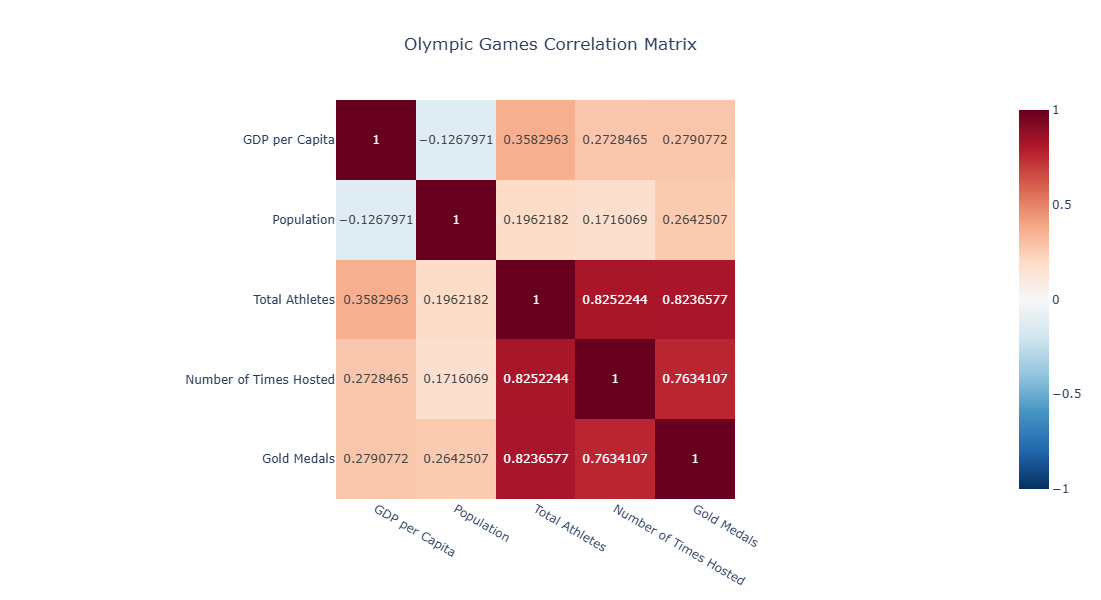

In [56]:
# Create 'super_table' combining all tables
super_table = plot_df.copy()

# Population merge
population_copy = merged_pop.copy()
super_table = pd.merge(
    super_table,
    population_copy[['Country_Standard','2024']],
    on='Country_Standard',
    how='inner'
)

# Number of participants merge
participants_copy = merged_participant_medal.copy()
super_table = pd.merge(
    super_table,
    participants_copy[['Country','Unique_Athletes']],
    left_on='Country_Standard',
    right_on='Country',
    how='inner'
)

# Number of times hosted merge
host_counts = host_with_medals['Country'].value_counts().reset_index()
host_counts.columns = ['Country', 'Times_Hosted']
super_table = pd.merge(
    super_table,
    host_counts,
    left_on='Country_Standard',
    right_on='Country',
    how='left').fillna({'Times_Hosted': 0})

# Tidying em up
super_table.drop(columns=['NOC', 'Country_x', 'Country_y', 'Total'], inplace=True)
super_table.columns = ['Country', 'GDP per Capita', 'Gold Medals', 'Population', 'Total Athletes', 'Number of Times Hosted']
desired_order = ['Country', 'GDP per Capita', 'Population', 'Total Athletes', 'Number of Times Hosted', 'Gold Medals']
super_table = super_table[desired_order]

# Correlation matrix
corr_matrix = super_table.corr(numeric_only=True)

# Create interactive heatmap
fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1,
    title="Olympic Games Correlation Matrix"
)

fig.update_layout(
    title_x=0.5,  # center the title
    width=800, height=600
)

fig.write_html("Plot_correlation_matrix.html", include_plotlyjs='cdn', full_html=True)
fig.show()